# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
49348,49348,US,"Light salmon-pink in color, this refreshing wi...",Estate,89,40.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Jericho Canyon Vineyard 2013 Estate Rosé (Napa...,Rosé,Jericho Canyon Vineyard
73211,73211,US,"This wine is dryish, crisp in acidity and clea...",Estate Grown,86,15.0,California,Central Coast,Central Coast,NaN,NaN,Clos La Chance 2013 Estate Grown Sauvignon Bla...,Sauvignon Blanc,Clos La Chance
35526,35526,Spain,Yeasty floral aromas are a touch soapy and not...,Tresor Rosé,87,15.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Pere Ventura NV Tresor Rosé Sparkling (Cava),Sparkling Blend,Pere Ventura
12186,12186,US,"Overly sweet and lacking in vibrant acidity, t...",Estate,84,80.0,California,Oakville,Napa,NaN,NaN,Cosentino 2005 Estate Cabernet Sauvignon (Oakv...,Cabernet Sauvignon,Cosentino
23041,23041,US,"A rich, thick, inky purple Petite Sirah with a...",Estate Grown,88,30.0,California,Shenandoah Valley (CA),Sierra Foothills,Virginie Boone,@vboone,Di Arie 2009 Estate Grown Petite Sirah (Shenan...,Petite Sirah,Di Arie


In [6]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [7]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

In [10]:
all_features = train_data.columns.tolist()#.remove("description")#.head()
all_features.remove("points")
print(all_features)

['country', 'description', 'designation', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


### Baselines

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [13]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.580948
MAE    2.538293
R2    -0.000013
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [14]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.635054
Armenia                   87.500000
Australia                 88.588269
Austria                   90.170591
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [15]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.103050
MAE    2.471748
R2     0.049867
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [16]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.766106
           Other               85.856098
Armenia    Armenia             87.500000
Australia  Australia Other     85.494382
           New South Wales     87.672131
Name: basiline_3_predicted_points, dtype: float64

In [17]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [18]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.521280
MAE    2.374959
R2     0.110590
dtype: float64

### Baselines summary

In [19]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590


In [20]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [22]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [23]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [24]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [25]:
train_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87
5,38,263,758,6,12,591,14706,15.0,87


#### Fitting a tree-regressor

In [26]:
from src.models import i_feel_lucky_xgboost_training

In [27]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [28]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [29]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
1,32,108,738,6,16,451,12956,15.0,87,88
6,22,332,1205,6,9,186,15014,16.0,87,87
13,22,332,424,6,9,388,10819,-1.0,87,87
25,41,51,1009,13,19,441,2512,69.0,87,92
26,22,332,1063,6,9,691,14472,13.0,87,87


In [30]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.266022
MAE    1.894325
R2     0.345983
dtype: float64

In [31]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983


In [32]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

In [33]:
desc = wine_reviews.copy()[["description","points"]]

In [34]:
desc.sample(5)

,description,points
71125,"Produced by the transfer method, with gas leve...",86
81635,"Based on Cabernet Sauvignon, this Bordeaux-sty...",92
75317,"A generous, well-balanced and wonderfully laye...",90
62088,This friendly wine starts with a spicy and aro...,87
46486,"Black plum, licorice and cool green-herb aroma...",91


In [35]:
desc.shape

(119988, 2)

In [36]:
desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  119988 non-null  object
 1   points       119988 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [37]:
import plotly.express as px

80       397
81       689
82      1814
83      2963
84      6225
85      9067
86     11526
87     15279
88     15291
89     11147
90     13893
91     10559
92      8951
93      6170
94      3625
95      1514
96       521
97       228
98        77
99        33
100       19
Name: points, dtype: int64

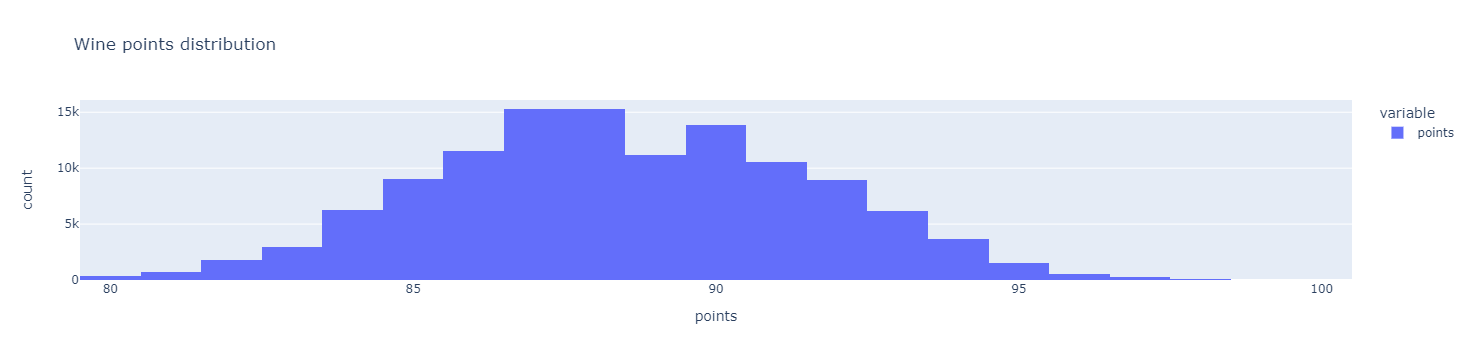

In [38]:
display(desc.points.value_counts().sort_index())
px.histogram(desc.points, labels={"value":"points"}, title="Wine points distribution")

In [39]:
desc

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90


In [40]:
import string
import emoji
import re as regex

In [41]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(text, regexp):
    return text.replace(regexp, "")

def remove_urls(text):
    return remove_by_regex(text, regex.compile(r"http\S+"))

def remove_special_chars(text): 
    return text.apply(lambda text: ''.join([c for c in text if c not in specialChars]))

def remove_usernames(text):
    return remove_by_regex(text, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(text):
    return remove_by_regex(text, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(text):
    return text.apply(lambda text: ''.join(c for c in text if c not in emoji.UNICODE_EMOJI))

def add_spaces(text):
    def add_spaces_int(text):
        for char in space_chars:
            text = text.replace(char, char + ' ')
        return text
    return text.apply(lambda text: add_spaces_int(text))

def leave_language_only(text):
    for f in [remove_urls, remove_emojis, add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        text = f(text)
    return text

In [42]:
desc['pureTextDescription'] = leave_language_only(desc.description.str.lower())
desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   description          119988 non-null  object
 1   points               119988 non-null  int64 
 2   pureTextDescription  119988 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [43]:
desc[['description','pureTextDescription']].sample(3)

,description,pureTextDescription
25046,"Lushly textured, this weaves sophisticated fla...",lushly textured this weaves sophisticated fla...
32442,This 100% Touriga Nacional wine is tight in ch...,this touriga nacional wine is tight in charact...
24751,There are light and airy elements of nectarine...,there are light and airy elements of nectarine...


Split to train & test samples:

In [44]:
train_desc = desc.sample(frac = 0.8)
test_desc = desc[~desc.index.isin(train_desc.index)]

In [45]:
len(train_desc) + len(test_desc) == len(desc)

True

In [46]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [47]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")

In [48]:
# desc['original_lower_cased_description'] = desc.description.str.lower()
all_words = [word for description in train_desc.pureTextDescription for word in nltk.word_tokenize(description) if word not in stopwords] # Words without stop words

In [49]:
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,wine,57558,0.000012
1,flavors,46228,0.000015
2,fruit,33312,0.000021
3,aromas,29077,0.000024
4,palate,27848,0.000025


In [50]:
test_words = [word for description in test_desc.pureTextDescription for word in nltk.word_tokenize(description) if word not in stopwords] # Words without stop words
test_words_df = pd.DataFrame(data = test_words, columns = ['word']).word.value_counts().reset_index()
test_words_df.columns = ['word','wordCount']
test_words_df['wordImportance'] = len(test_words_df) / test_words_df.wordCount / test_words_df.wordCount.max()
test_words_df.head()

,word,wordCount,wordImportance
0,wine,14599,0.000097
1,flavors,11730,0.000121
2,fruit,8263,0.000171
3,aromas,7165,0.000197
4,palate,6878,0.000206


In [51]:
import numpy as np

In [52]:
np.logspace(-2, 4, num=50, endpoint=True, base=10.0)

array([1.00000000e-02, 1.32571137e-02, 1.75751062e-02, 2.32995181e-02,
       3.08884360e-02, 4.09491506e-02, 5.42867544e-02, 7.19685673e-02,
       9.54095476e-02, 1.26485522e-01, 1.67683294e-01, 2.22299648e-01,
       2.94705170e-01, 3.90693994e-01, 5.17947468e-01, 6.86648845e-01,
       9.10298178e-01, 1.20679264e+00, 1.59985872e+00, 2.12095089e+00,
       2.81176870e+00, 3.72759372e+00, 4.94171336e+00, 6.55128557e+00,
       8.68511374e+00, 1.15139540e+01, 1.52641797e+01, 2.02358965e+01,
       2.68269580e+01, 3.55648031e+01, 4.71486636e+01, 6.25055193e+01,
       8.28642773e+01, 1.09854114e+02, 1.45634848e+02, 1.93069773e+02,
       2.55954792e+02, 3.39322177e+02, 4.49843267e+02, 5.96362332e+02,
       7.90604321e+02, 1.04811313e+03, 1.38949549e+03, 1.84206997e+03,
       2.44205309e+03, 3.23745754e+03, 4.29193426e+03, 5.68986603e+03,
       7.54312006e+03, 1.00000000e+04])

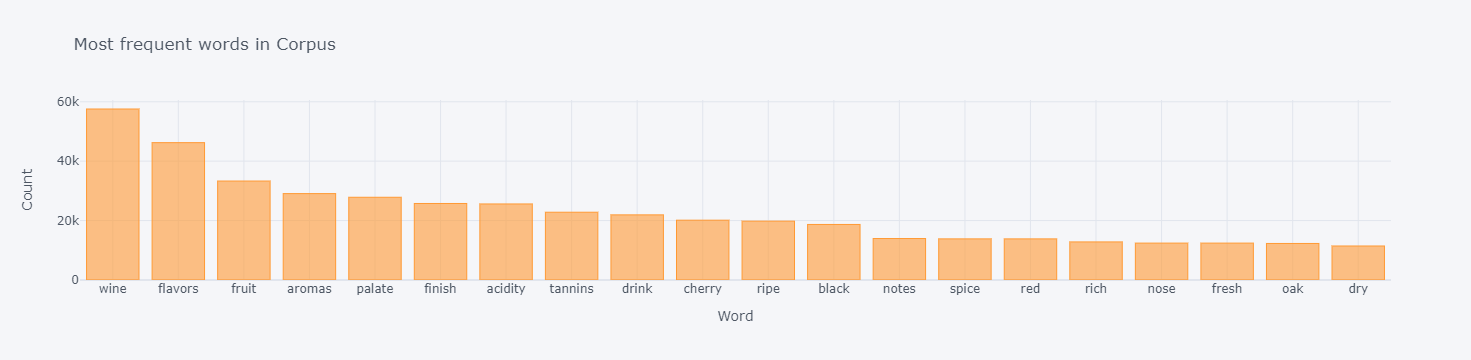

In [53]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [54]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 2359758 words, 40108 unique words


to reduce the corpus size more, we probably don't care about words that appear to little. Let's drop any word which have under 5 appearnces:

In [55]:
print ("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 5)))

Using words with 5 or more appearnces will reduce the corpus size to: 11708


In [56]:
words_df = words_df[words_df.wordCount >= 5]

### Bag of words (One-hot-encoding)

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts = count_vect.fit_transform(train_desc.pureTextDescription)
clean_bow_counts.shape

(95990, 11708)

In [59]:
train_desc.iloc[1].pureTextDescription

'rich and layered in cherries  red currants  pepper and gingerbread  this zin has soft  lush tannins and a spicy finish  its a good wine to drink with barbecue '

In [60]:
print(clean_bow_counts[1])

  (0, 684)	1
  (0, 1744)	1
  (0, 2561)	1
  (0, 3079)	1
  (0, 3800)	1
  (0, 4347)	1
  (0, 4425)	1
  (0, 5599)	1
  (0, 5964)	1
  (0, 7404)	1
  (0, 8253)	1
  (0, 8518)	1
  (0, 9452)	1
  (0, 9601)	1
  (0, 10237)	1
  (0, 11493)	1
  (0, 11680)	1


In [61]:
test_clean_vocab = set(test_words_df.word)
test_count_vect = CountVectorizer(vocabulary = test_clean_vocab, tokenizer=nltk.word_tokenize)
test_clean_bow_counts = count_vect.fit_transform(test_desc.pureTextDescription)
test_clean_bow_counts.shape

(23998, 11708)

In [62]:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[236])
print(rev_dict[470])
print(rev_dict[851])
print(rev_dict[866])

almonds
aromatic
benefitting
berryflavored


In [63]:
clean_bow_counts.sum()

2315970

In [64]:
tf_idf_vectorizer = TfidfVectorizer(vocabulary = clean_vocab)
bow_tfidf = tf_idf_vectorizer.fit_transform(train_desc.pureTextDescription)
bow_tfidf.shape

(95990, 11708)

In [65]:
bow_tfidf.sum()

431408.4818244761

In [66]:
print(clean_bow_counts[1])

  (0, 684)	1
  (0, 1744)	1
  (0, 2561)	1
  (0, 3079)	1
  (0, 3800)	1
  (0, 4347)	1
  (0, 4425)	1
  (0, 5599)	1
  (0, 5964)	1
  (0, 7404)	1
  (0, 8253)	1
  (0, 8518)	1
  (0, 9452)	1
  (0, 9601)	1
  (0, 10237)	1
  (0, 11493)	1
  (0, 11680)	1


## Regression

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [68]:
from sklearn.model_selection import cross_validate

In [69]:
from sklearn.linear_model import Ridge # LogisticRegression
# from sklearn.linear_model import ElasticNet # LogisticRegression

### Regulatization Strength

In [70]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [71]:
train_desc.head()

,description,points,pureTextDescription
71444,"With light vanilla aromas, this is a ripe styl...",87,with light vanilla aromas this is a ripe styl...
125693,"Rich and layered in cherries, red currants, pe...",86,rich and layered in cherries red currants pe...
37036,Although this probably won't be easy to locate...,92,although this probably wont be easy to locate ...
41281,Mildly tropical on the nose and pleasant overa...,86,mildly tropical on the nose and pleasant overa...
14556,"White flowers, lemon peel and vanilla lead thi...",89,white flowers lemon peel and vanilla lead thi...


In [72]:
%%capture
search_grid = np.logspace(0, 2, num=40, endpoint=True, base=10.0)
mse_by_alpha, r2_by_alpha, mae_by_alpha = [], [], []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    # avg_score = cross_val_score(model, clean_bow_counts, y = desc.points, cv = 10, scoring = 'neg_mean_squared_error', error_score='raise').mean()
    # avg_score = np.abs(avg_score)
    # mse_by_alpha.append((alpha,avg_score))
    cv_results = cross_validate(model, clean_bow_counts, y = train_desc.points, cv = 10, scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error'], error_score='raise')
    
    avg_mse = np.abs(cv_results['test_neg_mean_squared_error'].mean())
    avg_r2 = cv_results['test_r2'].mean()
    avg_mae = np.abs(cv_results['test_neg_mean_absolute_error'].mean())
    
    mse_by_alpha.append((alpha,avg_mse))
    mae_by_alpha.append((alpha,avg_mae))
    r2_by_alpha.append((alpha,avg_r2))

    # break

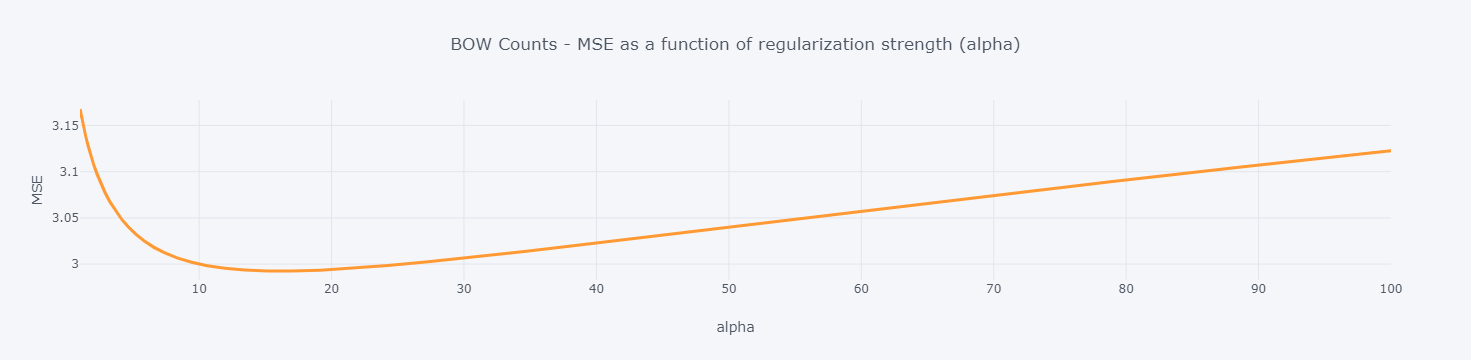

In [73]:
cv_results_mse = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results_mse.set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

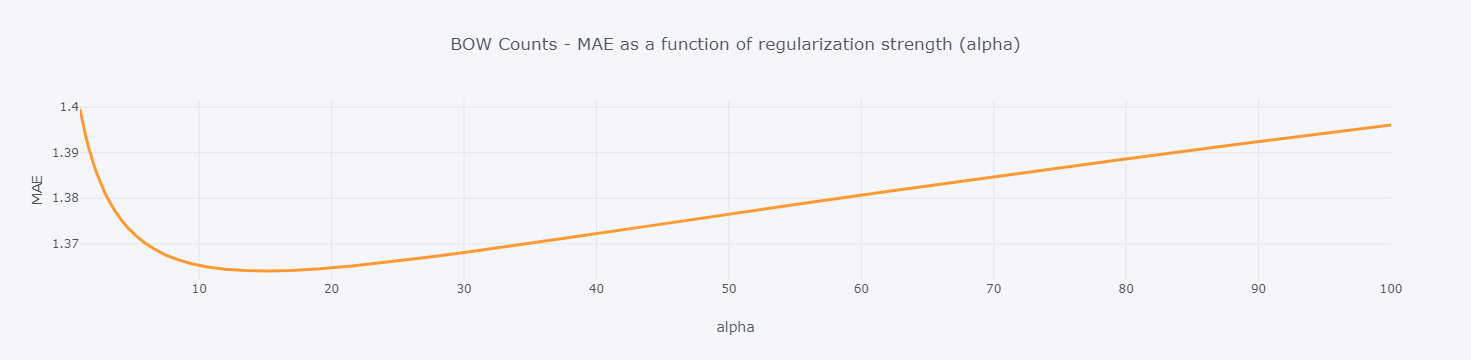

In [74]:
cv_results_mae = pd.DataFrame(mae_by_alpha, columns = ['alpha', 'MAE'])
cv_results_mae.set_index('alpha').MAE.iplot(title = 'BOW Counts - MAE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MAE', width = 3, hline=(0,0))

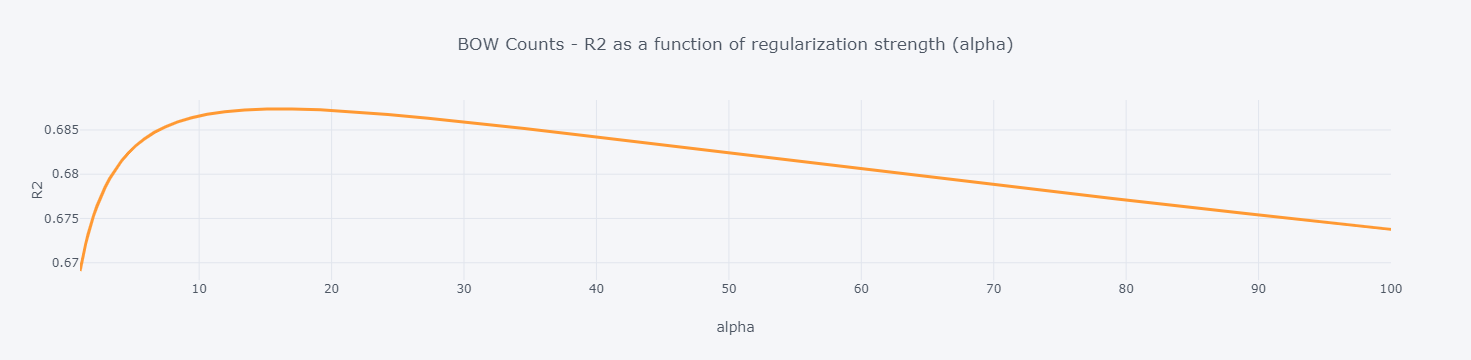

In [75]:
cv_results_r2 = pd.DataFrame(r2_by_alpha, columns = ['alpha', 'R2'])
cv_results_r2.set_index('alpha').R2.iplot(title = 'BOW Counts - R2 as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'R2', width = 3, hline=(0,0))

In [76]:
cv_results = pd.concat([cv_results_mse, cv_results_mae, cv_results_r2],axis=1)
assert cv_results.iloc[:,0].compare(cv_results.iloc[:,2]).empty and cv_results.iloc[:,0].compare(cv_results.iloc[:,4]).empty
cv_results = cv_results[["alpha","MSE","MAE","R2"]]
cv_results = cv_results.iloc[:,2:]
cv_results.head()

,alpha,MSE,MAE,R2
0,1.000000,3.167772,1.399589,0.669063
1,1.125336,3.158234,1.397652,0.670060
2,1.266380,3.148485,1.395700,0.671078
3,1.425103,3.138658,1.393709,0.672105
4,1.603719,3.128531,1.391673,0.673162


In [77]:
cv_results.loc[cv_results.R2.idxmax()]

alpha    17.012543
MSE       2.992510
MAE       1.364166
R2        0.687369
Name: 24, dtype: float64

In [78]:
cv_results.loc[cv_results.MSE.idxmin()]

alpha    17.012543
MSE       2.992510
MAE       1.364166
R2        0.687369
Name: 24, dtype: float64

In [79]:
cv_results.loc[cv_results.MAE.idxmin()]

alpha    15.117751
MSE       2.992532
MAE       1.364031
R2        0.687367
Name: 23, dtype: float64

In [80]:
opt_alpha = float(cv_results.loc[cv_results.MSE.idxmin(),"alpha"])
opt_alpha

17.012542798525892

### Optimal Model

Let's use the optimal model regularization parameter and train a model on the **entire dataset**:

In [81]:
model = Ridge(alpha=opt_alpha) #LogisticRegression(penalty='l2', C=(1/opt_alpha))
model.fit(clean_bow_counts, train_desc.points)

Ridge(alpha=17.012542798525892)

In [82]:
train_desc['predicted_points'] = model.predict(clean_bow_counts)

In [83]:
# accuracy_score(df.predicted_class, df.cls) # Training accuracy, for sanity only
mean_squared_error(train_desc.points, train_desc.predicted_points), mean_absolute_error(train_desc.points, train_desc.predicted_points), r2_score(train_desc.points, train_desc.predicted_points)

(2.5763484126148057, 1.2681658162557534, 0.7308997816604567)

In [84]:
test_clean_bow_counts

<23998x11708 sparse matrix of type '<class 'numpy.int64'>'
	with 561580 stored elements in Compressed Sparse Row format>

In [85]:
# model = Ridge(alpha=opt_alpha)
# model.fit(test_clean_bow_counts, test_desc.points)
test_desc['predicted_points'] = model.predict(test_clean_bow_counts)
BOW_stats = mean_squared_error(test_desc.points, test_desc.predicted_points), mean_absolute_error(test_desc.points, test_desc.predicted_points), r2_score(test_desc.points, test_desc.predicted_points)
BOW_stats

(2.981563943068975, 1.360872110704908, 0.6872845989954313)

In [86]:
BOW_stats = pd.Series(data=BOW_stats, index=["MSE","MAE","R2"])
BOW_stats

MSE    2.981564
MAE    1.360872
R2     0.687285
dtype: float64

### Feature importance

In [87]:
weights = model.coef_.flatten()
words = [rev_dict[i] for i in range(len(weights))]
feature_weights = pd.DataFrame({'word': words, 'weight': weights, 'absW': abs(weights)})
feature_weights.sort_values(by = 'absW', ascending = False, inplace = True)
feature_weights.head(5)

,word,weight,absW
8802,sample,2.996480,2.996480
5884,longterm,1.547483,1.547483
7367,peat,1.453915,1.453915
5879,longlived,1.434052,1.434052
3583,extraordinary,1.348679,1.348679


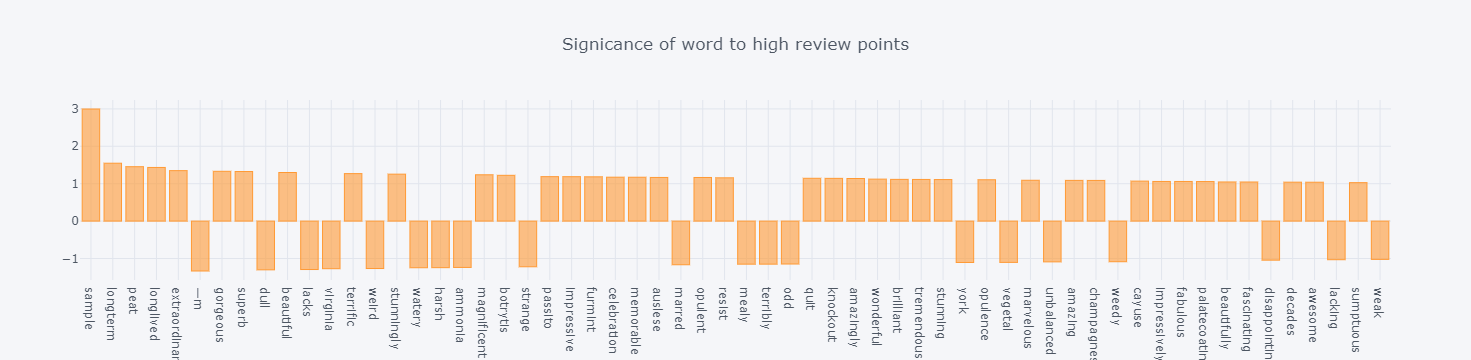

In [88]:
feature_weights.set_index('word').weight.head(60).iplot(kind = 'bar', title = 'Signicance of word to high review points', hline=(0,0))

In [89]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW"])
all_compared

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Using both the text and other features

## DATA PREP

In [90]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [91]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87


In [92]:
#replacing null price with more accurate mean (by features: country, province...)
# slices done using NA count per feature - wine_reviews.info()
wines = wine_reviews.copy()
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'region_2', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'region_1', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'province', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'winery'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines['price'].fillna(wines.groupby(['country', 'variety'])['price'].transform('mean'))
print(wines.price.isna().sum())
wines['price'] = wines.price.fillna(wines.price.mean())
print(wines.price.isna().sum())

8395
8270
4263
2675
2558
1584
11
0


In [93]:
#encoding wines df with replaced mean
encoded = wines[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
#encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded['price'] = wines.price
encoded['points'] = wines.points
encoded.head(2)

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,19.0,87
1,32,108,738,6,16,451,12956,15.0,87


In [94]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

In [95]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hagai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [96]:
#1 break the wines description to tokens using nltk.word_tokenize
wines = wine_reviews.copy()
wines['description_lowercase'] = wines.description.apply(lambda desc: desc.lower())
wines['desc_tokens'] = wines.description_lowercase.apply(lambda desc: nltk.word_tokenize(desc))
#remove punctuation
wines['desc_tokens'] = wines.desc_tokens.apply(lambda words: [word for word in words if word.isalnum()])

In [97]:
wines[['desc_tokens', 'description_lowercase']].sample(2)

,desc_tokens,description_lowercase
47139,"[this, wine, is, lean, and, still, young, with...","this wine is lean and still young, with concen..."
64865,"[complex, and, structured, this, has, rich, ta...","complex and structured, this has rich tannins ..."


In [98]:
############ resplitting wines to train and test
train_data = wines[wines.index.isin(train_data.index)]
test_data = wines[wines.index.isin(test_data.index)]
assert(train_data.shape[0] + test_data.shape[0]  == wines.shape[0])

In [99]:
####building the vocab only from training
#2 words wo stopwords to list
stopwords=nltk.corpus.stopwords.words("english")
all_words = [word for lst in wines.desc_tokens for word in lst if word.lower() not in stopwords] # Words without stop words
####building the vocab only from training
trn_words = [word for lst in train_data.desc_tokens for word in lst if word.lower() not in stopwords]

In [100]:
####building the vocab only from training
#3 create df + count the apperances
words_df = pd.DataFrame(data = trn_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']

In [101]:
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
# print(words_df.loc[0])
# print(len(words_df), words_df.wordCount[0], words_df.wordCount.max())
words_df.head(3)

,word,wordCount,wordImportance
0,wine,59241,0.000008
1,flavors,46336,0.000010
2,fruit,33318,0.000014


In [102]:
#defining the vocabulary:
#from train data only and appeared n_appear or above
#choosing 5 - as smaller may lead to overfit
n_appear = 5
vocab = set(words_df[words_df.wordCount >= n_appear].word) #set of all the words in vocab that appear n_appear or more

In [103]:
# sparse matrixes from train and test df
count_vect = CountVectorizer(vocabulary = vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_data.description_lowercase)
test_bow_counts = count_vect.fit_transform(test_data.description_lowercase)
assert(train_bow_counts.shape[0] + test_bow_counts.shape[0]  == wines.shape[0])
print('train:', train_bow_counts.shape[0], ' + test:',test_bow_counts.shape[0], ' = ', wines.shape[0])

train: 95990  + test: 23998  =  119988


In [104]:
print(train_data.iloc[1].desc_tokens)
#reverse dictionary rev_dict[word_num] ->word - print some examples:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[78])
print(rev_dict[260])
print(rev_dict[9040])
print(rev_dict[9348])
print(rev_dict[10426])

['tart', 'and', 'snappy', 'the', 'flavors', 'of', 'lime', 'flesh', 'and', 'rind', 'dominate', 'some', 'green', 'pineapple', 'pokes', 'through', 'with', 'crisp', 'acidity', 'underscoring', 'the', 'flavors', 'the', 'wine', 'was', 'all', 'fermented']
2013
achieving
stringy
tangerine
win


In [105]:
### resplitting encoded to train and test
train_enc = encoded_features[encoded_features.index.isin(train_data.index)].iloc[:,0:8]
test_enc = encoded_features[encoded_features.index.isin(test_data.index)].iloc[:,0:8]
assert(train_enc.shape[0] + test_enc.shape[0]  == encoded_features.shape[0])

In [106]:
### combining sparse encoded features with bow
from scipy.sparse import coo_matrix, hstack

train_features_sparse = coo_matrix(train_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
train_united_features = hstack((train_features_sparse, train_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
test_features_sparse = coo_matrix(test_enc) #constract sparse matrix from encoded df (next step to concat with BoW)
test_united_features = hstack((test_features_sparse, test_bow_counts)) #stack arrays in sequence horizontally (col wise) - aka concat the 6 features with 2030
assert(train_united_features.shape[0] + test_united_features.shape[0]  == encoded_features.shape[0])
print('train:', train_united_features.shape, ' + test:',test_united_features.shape, ' = ', encoded_features.shape)

train: (95990, 10609)  + test: (23998, 10609)  =  (119988, 9)


## END DATA PREP

In [107]:
train_enc.head()

,country,province,region_1,region_2,taster_name,variety,winery,price
0,22,332,424,6,9,691,11608,-1.0
2,41,269,1218,17,15,437,13018,14.0
3,41,218,549,6,0,480,14390,13.0
4,41,269,1218,17,15,441,14621,65.0
5,38,263,758,6,12,591,14706,15.0


In [108]:
opt_alpha=12.915496650148826

In [109]:
#run fit using train bow sparse matrix
#using opt_alpha from above
united_lreg = Ridge(alpha=opt_alpha, tol=1e-4)
united_lreg.fit(train_united_features, y = train_data.points)

Ridge(alpha=12.915496650148826, tol=0.0001)

In [110]:
#use model to predict using test bow sparse matrix
united_lreg_test = test_data.copy()
united_lreg_test['united_lin_reg'] = united_lreg.predict(test_united_features)
#united_lreg_test.sample(1)

In [111]:
calc_prediction_quality(united_lreg_test, 'united_lin_reg','points')

MSE    2.839725
MAE    1.327986
R2     0.703603
dtype: float64

### Search grid with higher granularity around the the area suspected to yield best results:

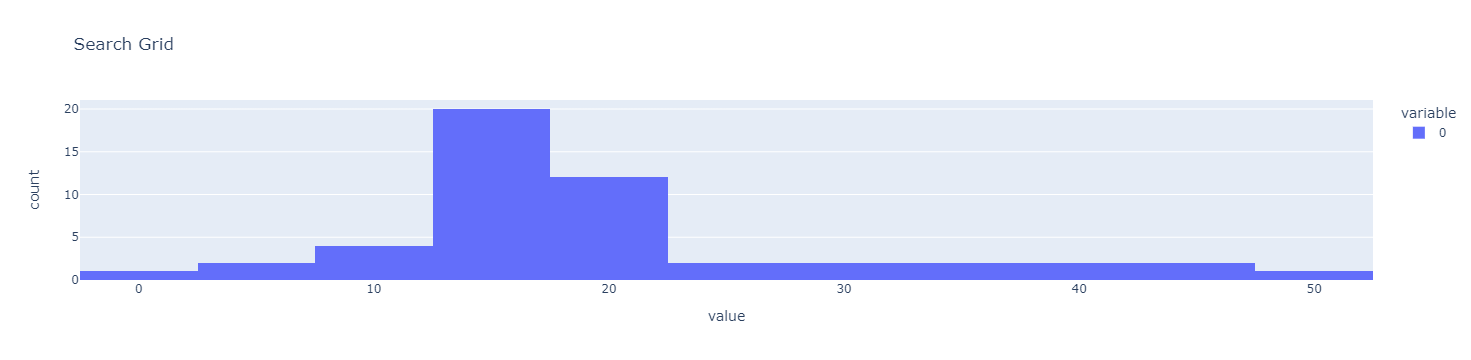

array([1.00000000e-03, 2.63252632e+00, 5.26405263e+00, 7.89557895e+00,
       1.05271053e+01, 1.20000000e+01, 1.22758621e+01, 1.25517241e+01,
       1.28275862e+01, 1.31034483e+01, 1.31586316e+01, 1.33793103e+01,
       1.36551724e+01, 1.39310345e+01, 1.42068966e+01, 1.44827586e+01,
       1.47586207e+01, 1.50344828e+01, 1.53103448e+01, 1.55862069e+01,
       1.57901579e+01, 1.58620690e+01, 1.61379310e+01, 1.64137931e+01,
       1.66896552e+01, 1.69655172e+01, 1.72413793e+01, 1.75172414e+01,
       1.77931034e+01, 1.80689655e+01, 1.83448276e+01, 1.84216842e+01,
       1.86206897e+01, 1.88965517e+01, 1.91724138e+01, 1.94482759e+01,
       1.97241379e+01, 2.00000000e+01, 2.10532105e+01, 2.36847368e+01,
       2.63162632e+01, 2.89477895e+01, 3.15793158e+01, 3.42108421e+01,
       3.68423684e+01, 3.94738947e+01, 4.21054211e+01, 4.47369474e+01,
       4.73684737e+01, 5.00000000e+01])

In [112]:
search_grid1 = np.linspace(0.001, 50, num=20, endpoint=True)
search_grid2 = np.linspace(12, 20, num=30, endpoint=True)

search_grid3 = np.concatenate((search_grid1, search_grid2))
search_grid3.sort()
search_grid = search_grid3
fig = px.histogram(search_grid, title="Search Grid")
fig.show()
search_grid

In [113]:
%%capture
# search_grid = [0,0.03,0.1,0.3,1,5,15,45,150,500,1500]#,np.logspace(0, 6, num=50, endpoint=True, base=10.0)
mse_by_alpha, r2_by_alpha, mae_by_alpha = [], [], []
for alpha in search_grid:
    model = Ridge(alpha=alpha, tol=0.00001, max_iter=100000)
    # avg_score = cross_val_score(model, train_united_features, y = df.cls, cv = 10, scoring = 'roc_auc').mean()
    # auc_by_alpha.append((alpha,avg_score))
    
    cv_results = cross_validate(model, train_united_features, y = train_data.points, cv = 10, scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error'], error_score='raise')
    
    avg_mse = np.abs(cv_results['test_neg_mean_squared_error'].mean())
    avg_r2 = cv_results['test_r2'].mean()
    avg_mae = np.abs(cv_results['test_neg_mean_absolute_error'].mean())
    
    mse_by_alpha.append((alpha,avg_mse))
    mae_by_alpha.append((alpha,avg_mae))
    r2_by_alpha.append((alpha,avg_r2))

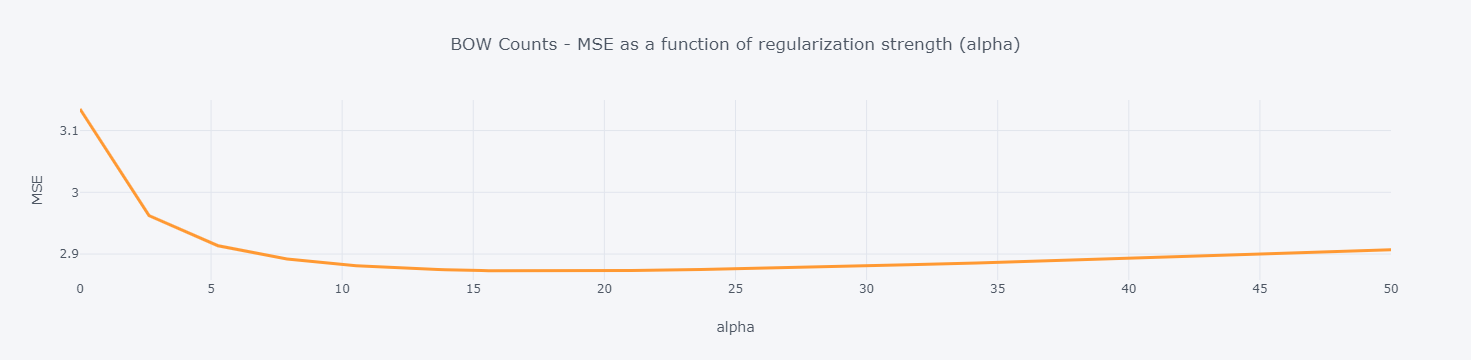

In [114]:
cv_results_mse = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results_mse.set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

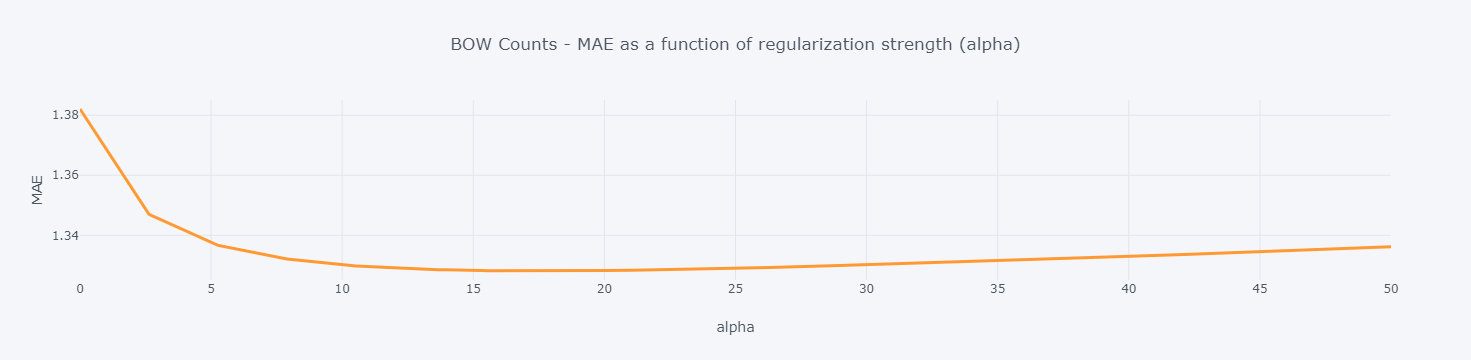

In [115]:
cv_results_mae = pd.DataFrame(mae_by_alpha, columns = ['alpha', 'MAE'])
cv_results_mae.set_index('alpha').MAE.iplot(title = 'BOW Counts - MAE as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'MAE', width = 3, hline=(0,0))

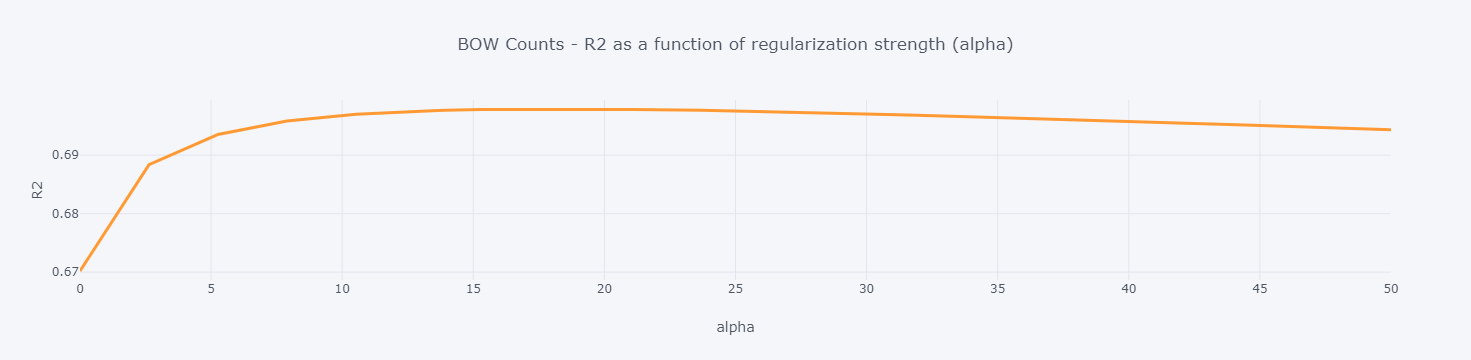

In [116]:
cv_results_r2 = pd.DataFrame(r2_by_alpha, columns = ['alpha', 'R2'])
cv_results_r2.set_index('alpha').R2.iplot(title = 'BOW Counts - R2 as a function of regularization strength (alpha)', xTitle = 'alpha', yTitle = 'R2', width = 3, hline=(0,0))

If all features are not better than TEXT alone - use all features, but with text-predicted-score instead of TEXT.

In [117]:
cv_results = pd.concat([cv_results_mse, cv_results_mae, cv_results_r2],axis=1)
assert cv_results.iloc[:,0].compare(cv_results.iloc[:,2]).empty and cv_results.iloc[:,0].compare(cv_results.iloc[:,4]).empty
cv_results = cv_results[["alpha","MSE","MAE","R2"]]
cv_results = cv_results.iloc[:,2:]
cv_results.head()

,alpha,MSE,MAE,R2
0,0.001000,3.134846,1.382073,0.670200
1,2.632526,2.962422,1.346999,0.688396
2,5.264053,2.913515,1.336678,0.693552
3,7.895579,2.891919,1.332131,0.695832
4,10.527105,2.881018,1.329807,0.696988


In [118]:
cv_results.loc[cv_results.MSE.idxmin()]

alpha    17.517241
MSE       2.872590
MAE       1.328131
R2        0.697894
Name: 27, dtype: float64

In [119]:
cv_results.loc[cv_results.MAE.idxmin()]

alpha    17.517241
MSE       2.872590
MAE       1.328131
R2        0.697894
Name: 27, dtype: float64

In [120]:
cv_results.loc[cv_results.R2.idxmax()]

alpha    18.068966
MSE       2.872602
MAE       1.328156
R2        0.697895
Name: 29, dtype: float64

In [121]:
opt_alpha = float(cv_results.loc[cv_results.MSE.idxmin(),"alpha"])
opt_alpha

17.517241379310345

Test with optimal alpha:

In [122]:
model = Ridge(alpha=opt_alpha, tol=0.00001, max_iter=100000)
model.fit(train_united_features, train_data.points)

Ridge(alpha=17.517241379310345, max_iter=100000, tol=1e-05)

In [123]:
train_data['predicted_points'] = model.predict(train_united_features)

In [124]:
mean_squared_error(train_data.points, train_data.predicted_points), mean_absolute_error(train_data.points, train_data.predicted_points), r2_score(train_data.points, train_data.predicted_points)

(2.4935594919052875, 1.23953319128493, 0.7392308584389615)

In [125]:
test_data['predicted_points'] = model.predict(test_united_features)
NLP_all_features_stats = mean_squared_error(test_data.points, test_data.predicted_points), mean_absolute_error(test_data.points, test_data.predicted_points), r2_score(test_data.points, test_data.predicted_points)
NLP_all_features_stats

(2.818509134482017, 1.3242364734681662, 0.7058175966567389)

In [126]:
NLP_all_features_stats = pd.Series(data=NLP_all_features_stats, index=["MSE","MAE","R2"])
NLP_all_features_stats

MSE    2.818509
MAE    1.324236
R2     0.705818
dtype: float64

In [127]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features"])
all_compared

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [128]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [129]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [130]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [131]:
vectorize_layer.adapt(train_data['description'])

In [132]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Tempting aromas like vanilla and coconut lead to ripe, opulent plum and blackberry flavors and a sensation of sweetness in this full-bodied but smooth and gentle wine.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([2390,   17,  105,   65,    2,  546,  152,   13,   27,  494,   45,
          2,   51,   10,    2,    4, 1711,    5,  300,   11,    7,  138,
         23,   96,    2,  534,    9,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [133]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

2390 --->  tempting
17 --->  aromas
105 --->  like
65 --->  vanilla
2 --->  and
546 --->  coconut
152 --->  lead
13 --->  to
27 --->  ripe
494 --->  opulent
45 --->  plum
2 --->  and
51 --->  blackberry
10 --->  flavors
2 --->  and
4 --->  a
1711 --->  sensation
5 --->  of
300 --->  sweetness
11 --->  in


#### Modeling

In [134]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [135]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

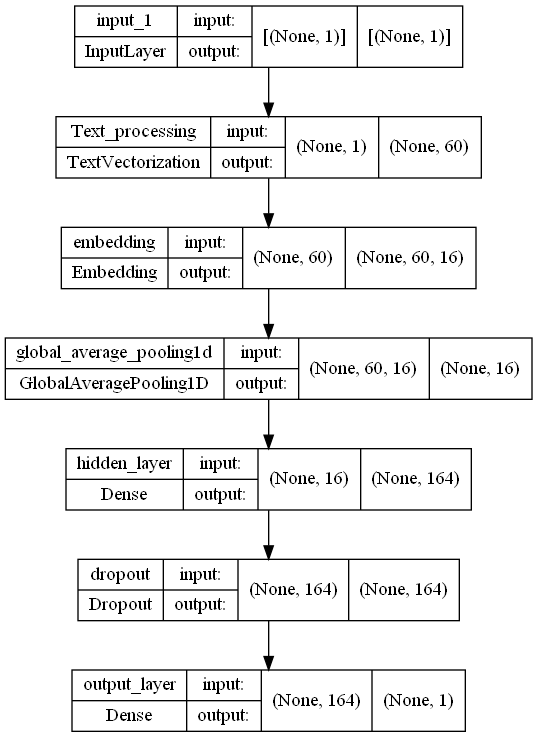

In [136]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [137]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [138]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 22.1807 - mean_squared_error: 1377.4612 - mean_absolute_error: 22.1807 - val_loss: 2.4733 - val_mean_squared_error: 9.2432 - val_mean_absolute_error: 2.4733
Epoch 2/20
750/750 [==============================] - 6s 9ms/step - loss: 3.4512 - mean_squared_error: 18.7570 - mean_absolute_error: 3.4512 - val_loss: 1.7262 - val_mean_squared_error: 4.6612 - val_mean_absolute_error: 1.7262
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1730 - mean_squared_error: 15.8771 - mean_absolute_error: 3.1730 - val_loss: 1.5479 - val_mean_squared_error: 3.7992 - val_mean_absolute_error: 1.5479
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1224 - mean_squared_error: 15.3463 - mean_absolute_error: 3.1224 - val_loss: 1.4590 - val_mean_squared_error: 3.3781 - val_mean_absolute_error: 1.4590
Epoch 5/20
750/750 [==============================] - 7s 9ms/step - loss: 3.0881 - mean_

### Simple NN Prediction & Evaluation

In [139]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [140]:
DNN_text_only_Average = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
DNN_text_only_Average

MSE    3.071684
MAE    1.384459
R2     0.679392
dtype: float64

In [141]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats,DNN_text_only_Average], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features", "DNN_text_only_Average"])
all_compared

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818
DNN_text_only_Average,3.071684,1.384459,0.679392


### Descriptions words concatinated

In [142]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [143]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [144]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

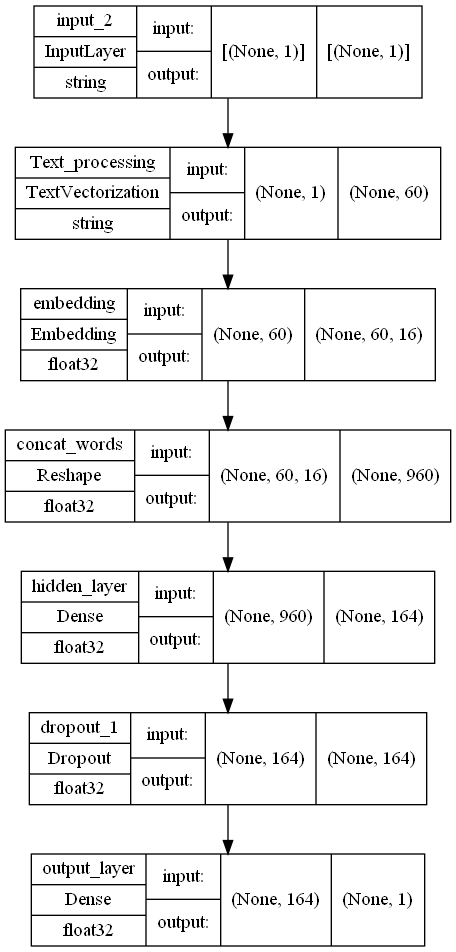

In [145]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [146]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 8s 10ms/step - loss: 24.3667 - mean_squared_error: 1108.7478 - mean_absolute_error: 24.3667 - val_loss: 2.6595 - val_mean_squared_error: 10.9935 - val_mean_absolute_error: 2.6595
Epoch 2/20
750/750 [==============================] - 7s 9ms/step - loss: 8.7085 - mean_squared_error: 118.9841 - mean_absolute_error: 8.7085 - val_loss: 2.6718 - val_mean_squared_error: 11.1523 - val_mean_absolute_error: 2.6718
Epoch 3/20
750/750 [==============================] - 7s 9ms/step - loss: 8.7064 - mean_squared_error: 118.6583 - mean_absolute_error: 8.7064 - val_loss: 2.6713 - val_mean_squared_error: 11.1477 - val_mean_absolute_error: 2.6713
CPU times: total: 1min 8s
Wall time: 21.2 s


In [147]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [148]:
DNN_text_only_Concat = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
DNN_text_only_Concat

MSE    10.993521
MAE     2.659489
R2     -0.147451
dtype: float64

In [149]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats,BOW_stats,NLP_all_features_stats,DNN_text_only_Average,DNN_text_only_Concat], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',"BOW","NLP all features", "DNN_text_only_Average","DNN_text_only_Concat"])
all_compared

,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818
DNN_text_only_Average,3.071684,1.384459,0.679392
DNN_text_only_Concat,10.993521,2.659489,-0.147451


### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

#### Load pre-trained word embeddings

In [150]:
import os
import numpy as np

External embeddings source:
    https://github.com/stanfordnlp/GloVe
    (download and extract to appropriate path)

In [151]:
filename = "glove.840B.300d.txt" 
mypth = os.getcwd()
path_to_glove_file = mypth + "\\data\\" + filename
path_to_glove_file

'C:\\Users\\hagai\\Python_ML\\Python_ML-2022\\Final project\\data\\glove.840B.300d.txt'

#### dict mapping words (strings) to their NumPy vector representation:

In [152]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

C:\Users\hagai\AppData\Local\Temp\ipykernel_12464\954783006.py:5: DeprecationWarning:

string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.



Found 2195885 word vectors.


#### prepare embedding matrix 

In [153]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

In [154]:
train_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,description_lowercase,desc_tokens,predicted_points
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"aromas include tropical fruit, broom, brimston...","[aromas, include, tropical, fruit, broom, brim...",86.738143
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"tart and snappy, the flavors of lime flesh and...","[tart, and, snappy, the, flavors, of, lime, fl...",86.486006
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"pineapple rind, lemon pith and orange blossom ...","[pineapple, rind, lemon, pith, and, orange, bl...",87.020270
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"much like the regular bottling from 2012, this...","[much, like, the, regular, bottling, from, 201...",85.130196
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,blackberry and raspberry aromas show a typical...,"[blackberry, and, raspberry, aromas, show, a, ...",86.963601


In [155]:
sample_description = train_data['description_lowercase'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

this is a balanced, ripe wine full of apple and orange fruit, and with a fine, textured character. it has weight and caramel richness, and just a hint of wood. it should be aged before drinking, so wait until 2016.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([  7,   8,   4,  85,  27,   9,  69,   5,  49,   2, 135,  16,   2,
         6,   4, 113, 289,  82,  12,  30, 219,   2, 316, 164,   2, 103,
         4, 116,   5, 106,  12, 207,  94, 338, 394, 356, 125, 831, 433,
       414,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)>

In [156]:
num_tokens = len(vocab) + 2

embedding_dim = 300 # external embeddings has 300 dimensions
hits = 0
misses = 0

# Prepare embedding matrix
missing_words = []
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and len(embedding_vector)!=0:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        if len(embedding_vector)!=300:
            print("hits =",hits)
            print(len(embedding_vector))
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        missing_words.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19834 words (12166 misses)


In [157]:
#Examples of words in wines review that are NOT in the external vocabulary
if misses > 0:
    misses_i =np.min([misses-1,20])
    print(missing_words[0:misses_i])

['', '[UNK]', 'is', 'in', 'to', 'on', 'by', 'at', 'or', 'mediumbodied', 'offdry', 'blackfruit', 'easydrinking', 'redfruit', 'lightbodied', 'singlevineyard', 'hightoned', 'lemonlime', 'touriga', 'blackskinned']


In [158]:
substr = 'redfruit'
wines[wines.description.apply(lambda desc: True if substr in desc else False)].iloc[0,:].to_frame()

,59252
country,France
description,Produced from Cabernet Franc on the family-own...
designation,Les Rochettes
points,86
price,18.0
province,Loire Valley
region_1,Bourgueil
region_2,NaN
taster_name,Roger Voss
taster_twitter_handle,@vossroger


In [159]:
wines.description_lowercase.iloc[59252]

'the wine has all the right crispness and steeliness of a blanc de blancs chardonnay. it also has warmth, yellow fruits along with a touch of apple. that makes a wine that is full-bodied while not missing out on a tight, very fresh aftertaste.'

#### Create Embedding Layer

In [160]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
#    trainable=True,
)
# trainable=False so as to keep the embeddings fixed; True - will continue learning (very slow - high dim!)

#### Building the model

In [161]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [162]:
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 30
mloss = 'mse'
n_lr = 3e-4
active_f = 'tanh'

In [163]:
#create model
#using reshape to concat the vectors - should add also more info on order of words
#replaced embedding layer with pre-build embedding built using Glove external embedding
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(nn, activation=active_f, name='hidden_layer'),
    Dropout(ndropout),
    Dense(1, name = 'output_layer')
])

In [164]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [165]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 300)           9600600   
                                                                 
 concat_words (Reshape)      (None, 18000)             0         
                                                                 
 hidden_layer (Dense)        (None, 820)               14760820  
                                                                 
 dropout_2 (Dropout)         (None, 820)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 821       
                                                      

In [166]:
# pip install pydot

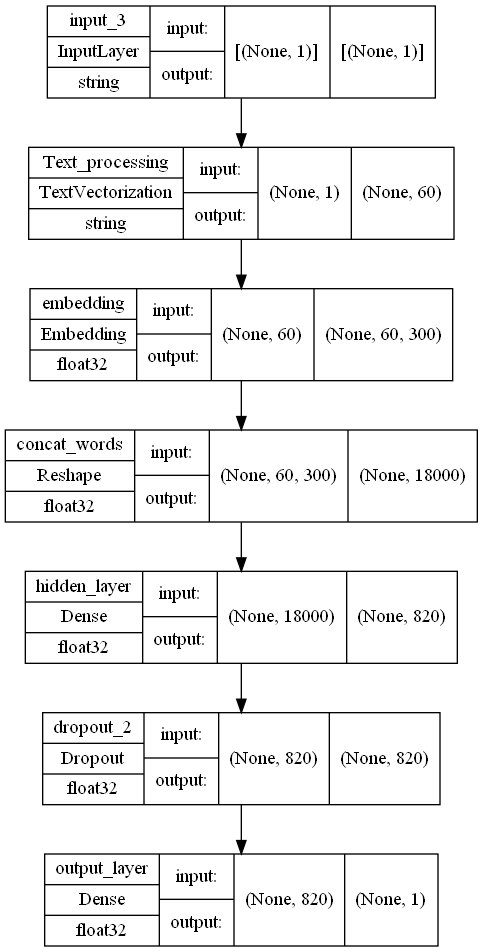

In [167]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [168]:
%%time
# # Approximately 20 minutes

text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
3000/3000 [==============================] - 141s 46ms/step - loss: 97.6636 - mean_squared_error: 97.6636 - mean_absolute_error: 4.8249 - val_loss: 4.3677 - val_mean_squared_error: 4.3677 - val_mean_absolute_error: 1.6669
Epoch 2/30
3000/3000 [==============================] - 147s 49ms/step - loss: 6.6856 - mean_squared_error: 6.6856 - mean_absolute_error: 2.0564 - val_loss: 4.0317 - val_mean_squared_error: 4.0317 - val_mean_absolute_error: 1.5929
Epoch 3/30
3000/3000 [==============================] - 146s 49ms/step - loss: 6.1756 - mean_squared_error: 6.1756 - mean_absolute_error: 1.9781 - val_loss: 3.8982 - val_mean_squared_error: 3.8982 - val_mean_absolute_error: 1.5621
Epoch 4/30
3000/3000 [==============================] - 144s 48ms/step - loss: 5.9526 - mean_squared_error: 5.9526 - mean_absolute_error: 1.9423 - val_loss: 3.8797 - val_mean_squared_error: 3.8797 - val_mean_absolute_error: 1.5605
Epoch 5/30
3000/3000 [==============================] - 147s 49ms/step - l

In [169]:
test_data['ext_embedding'] = model.predict(test_data[text_col])

C:\Users\hagai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\hagai\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



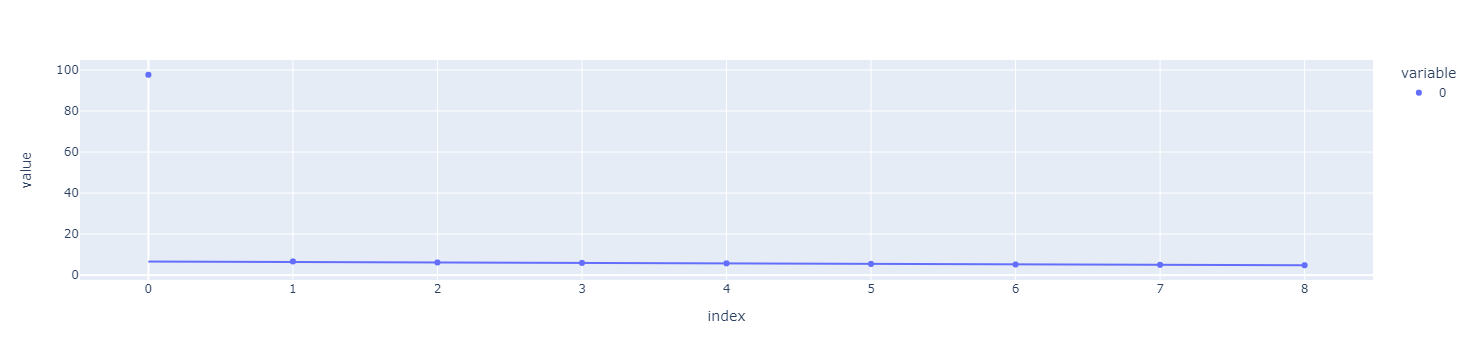

In [170]:
px.scatter(history.history["loss"],  trendline="lowess")

In [171]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'ext_embedding', target_col)
stats

MSE    3.837343
MAE    1.552801
R2     0.599477
dtype: float64

In [172]:
all_compared = all_compared.append(stats.to_frame(name='External_Embeddings_text_only_Concat').transpose())
all_compared

C:\Users\hagai\AppData\Local\Temp\ipykernel_12464\3262858933.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818
DNN_text_only_Average,3.071684,1.384459,0.679392
DNN_text_only_Concat,10.993521,2.659489,-0.147451
External_Embeddings_text_only_Concat,3.837343,1.552801,0.599477


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [173]:
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adamax, Nadam

In [174]:
#optimized params chosen
embedding_dim = 16
nn = 32
ndropout = 0.2 
active_f = 'tanh'
nbatch  = 64 #32
mloss = 'mse'
n_lr = 3e-3 #3e-4
#
nepochs = 30

#### create model

In [175]:
#create model with LSTM with Bidirectional wrapper
model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorize_layer,
        Embedding(vocab_size+1, embedding_dim, input_length= sequence_length, name="embedding", mask_zero=True),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu', name='hidden_layer'),
        Dense(1, name = 'output_layer')
    ])

In [176]:
optimizer = Adam(learning_rate=n_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [177]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512016    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 hidden_layer (Dense)        (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 561,809
Trainable params: 561,809
Non-tr

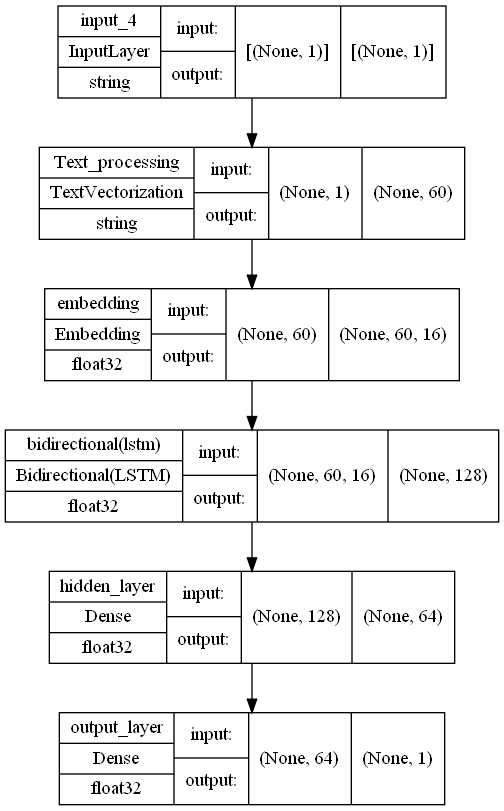

In [178]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [179]:
%%time
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=nepochs,
    batch_size=nbatch,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
1500/1500 [==============================] - 115s 72ms/step - loss: 98.2346 - mean_squared_error: 98.2346 - mean_absolute_error: 3.8220 - val_loss: 7.5006 - val_mean_squared_error: 7.5006 - val_mean_absolute_error: 2.1927
Epoch 2/30
1500/1500 [==============================] - 104s 69ms/step - loss: 4.2823 - mean_squared_error: 4.2823 - mean_absolute_error: 1.6025 - val_loss: 2.9444 - val_mean_squared_error: 2.9444 - val_mean_absolute_error: 1.3562
Epoch 3/30
1500/1500 [==============================] - 104s 70ms/step - loss: 2.6780 - mean_squared_error: 2.6780 - mean_absolute_error: 1.2859 - val_loss: 2.8436 - val_mean_squared_error: 2.8436 - val_mean_absolute_error: 1.3264
Epoch 4/30
1500/1500 [==============================] - 105s 70ms/step - loss: 2.4095 - mean_squared_error: 2.4095 - mean_absolute_error: 1.2167 - val_loss: 3.4204 - val_mean_squared_error: 3.4204 - val_mean_absolute_error: 1.4624
Epoch 5/30
1500/1500 [==============================] - 102s 68ms/step - l

In [180]:
test_data['LSTM'] = model.predict(test_data[text_col])

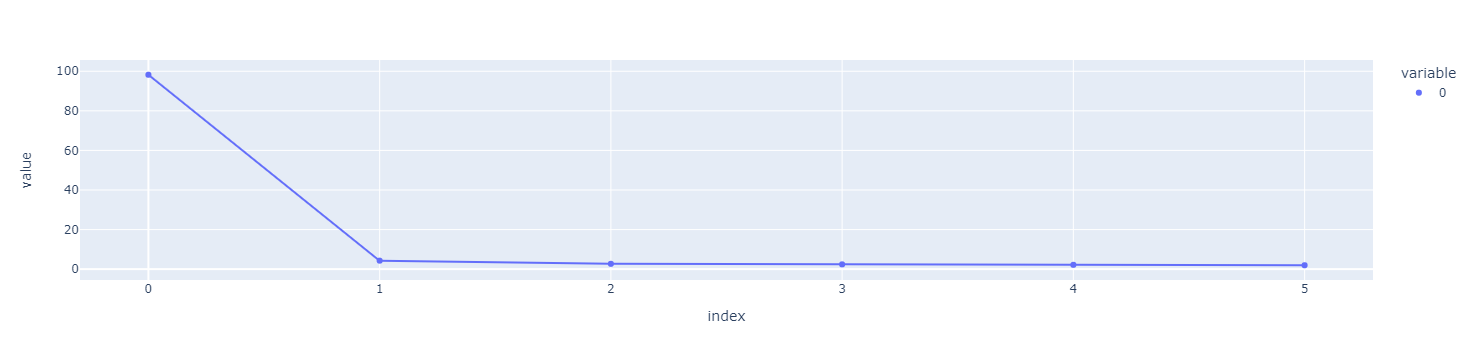

In [181]:
px.scatter(history.history["loss"],  trendline="lowess")

In [182]:
#check stats and add to comparison df
stats = calc_prediction_quality(test_data, 'LSTM', target_col)
stats

MSE    2.843597
MAE    1.326384
R2     0.703199
dtype: float64

In [183]:
all_compared = all_compared.append(stats.to_frame(name='LSTM').transpose())
all_compared

C:\Users\hagai\AppData\Local\Temp\ipykernel_12464\1341769081.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818
DNN_text_only_Average,3.071684,1.384459,0.679392
DNN_text_only_Concat,10.993521,2.659489,-0.147451
External_Embeddings_text_only_Concat,3.837343,1.552801,0.599477
LSTM,2.843597,1.326384,0.703199


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

In [184]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [185]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 10#30#10 #6 #30
mloss = 'mse'
n_lr = 5e-4 #1e-3
active_f = 'tanh'

In [186]:

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding --- 1st input ---
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data --- 2nd input ----
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate --- concat both inputs ---
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both inputs -> 1 output
model = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


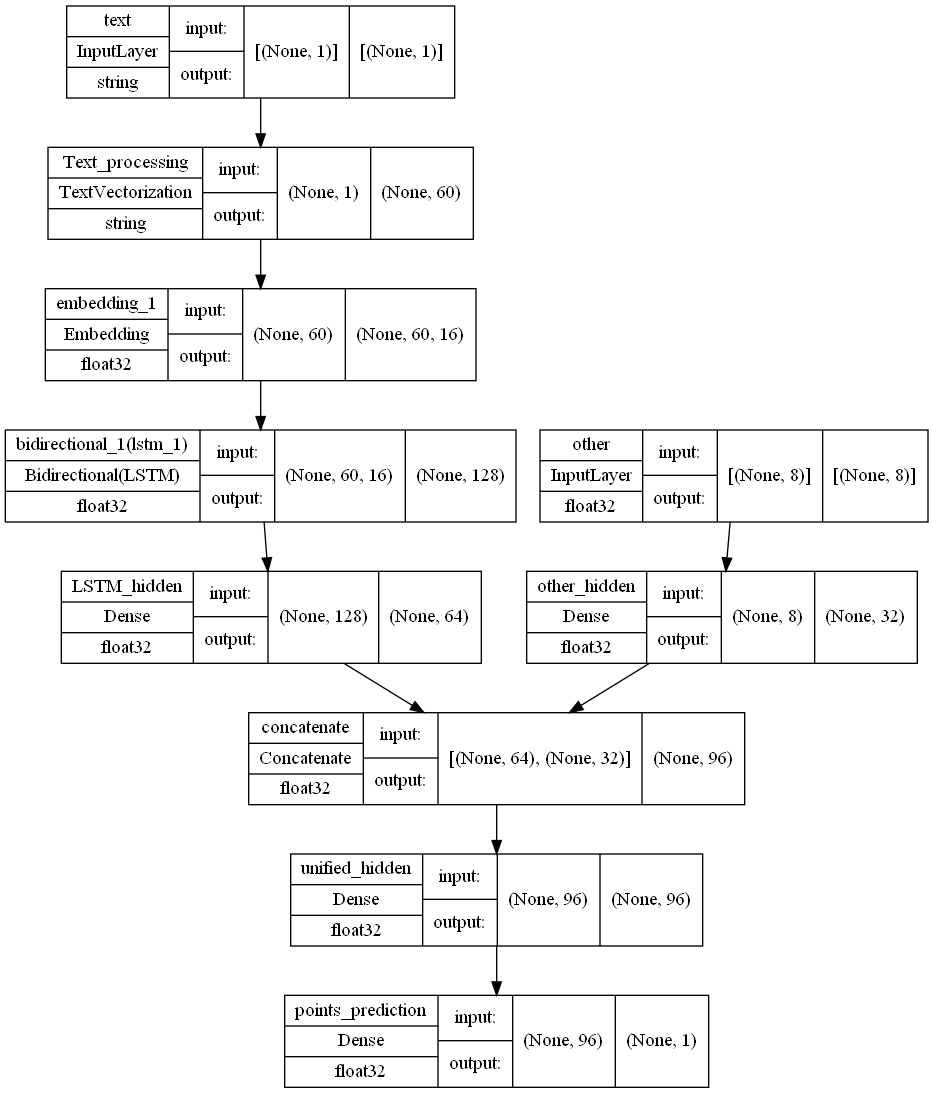

In [187]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [188]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Text_processing (TextVectoriza  (None, 60)          0           ['text[0][0]']                   
 tion)                                                                                            
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 16)       512000      ['Text_processing[4][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         41472       ['embedding_1[0][0]']        

In [189]:
train_y = encoded_features[encoded_features.index.isin(train_data.index)].points
test_y = encoded_features[encoded_features.index.isin(test_data.index)].points
assert(train_y.shape[0] + test_y.shape[0]  == encoded_features.shape[0])

In [190]:
from tensorflow.keras.callbacks import EarlyStopping

In [191]:
if test_enc.shape[1]>8 :
    test_enc = test_enc.iloc[:,:-2]
    # display(test_enc.head())

In [192]:
#for text data
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=2,#4,#2 #3
    verbose=0,
    restore_best_weights=True
)



In [193]:
n_lr

0.0005

In [194]:
[i/100 for i in [1, 3,10,30]]

[0.01, 0.03, 0.1, 0.3]

In [195]:
lr_list = [0.01, 0.03, 0.1, 0.3, 1, 3,10,30]
lr_list = [i*n_lr for i in lr_list]
lr_list

[5e-06, 1.5e-05, 5e-05, 0.00015, 0.0005, 0.0015, 0.005, 0.015]

### Choosing optimal Learning Rate:

In [196]:
# split train set to tune the learning rate parameter without bias:

train_data_tune_LR = train_data.sample(frac=0.75) # instead train_data
train_data_validate_LR = train_data[~train_data.index.isin(train_data_tune_LR.index)] # instead test_data
assert len(train_data_tune_LR) + len(train_data_validate_LR) == len(train_data)

train_enc_tune_LR = train_enc[train_enc.index.isin(train_data_tune_LR.index)] # instead train_enc
train_enc_validate_LR = train_enc[~train_enc.index.isin(train_data_tune_LR.index)] # instead test_enc
assert len(train_enc_tune_LR) + len(train_enc_validate_LR) == len(train_enc)

train_y_tune = train_data_tune_LR.points # instead train_y
train_y_validate = train_data_validate_LR.points # instead test_y

In [197]:
lr_list2 = [n_lr, 0.005, 0.015, 0.015*3, 0.015*3*3*3]
lr_list2

[0.0005, 0.005, 0.015, 0.045, 0.405]

In [198]:
# optimal_lr = res2.loc[res2.MSE.idxmin(),"LR"]
optimal_lr = 0.015 # Alternative
optimal_lr

0.015

### Train & Test with Optimal Learning Rate

In [199]:
#model parameters
embedding_dim = 16
nn = 820
ndropout = 0.2
nbatch = 32
nepochs = 10
mloss = 'mse'
n_lr = 5e-4 
active_f = 'tanh'

In [200]:
#params:
#vectorize_layer TextVectorization
#vocab_size = 32000
#sequence_length = 72 #60

#using the kerashape=unctional API to build a model with 2 inputs
#descrption text embedding --- 1st input ---
desc_input = keras.Input(shape=(1,), dtype="string", name="text")
token_input = vectorize_layer(desc_input)
desc_features = layers.Embedding(vocab_size, 16)(token_input)
#desc_features = layers.LSTM(128, name='text_LSTM')(desc_features)
desc_features = Bidirectional(LSTM(64))(desc_features)
desc_features = Dense(64, activation='relu', name='LSTM_hidden')(desc_features)
#other data --- 2nd input ----
other_input = keras.Input(shape=(8,), name="other")
other_features = layers.Dense(32, name="other_hidden")(other_input)
#concatenate --- concat both inputs ---
x = layers.concatenate([desc_features, other_features])
#hidden layer
hidden = layers.Dense(96, name="unified_hidden")(x)
#output
points_pred = layers.Dense(1, name="points_prediction")(hidden)
# Instantiate an end-to-end model from both inputs -> 1 output
model = keras.Model(
    inputs=[desc_input, other_input],
    outputs=[points_pred],
)


In [201]:
#for text data
text_col, target_col = 'description_lowercase', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    min_delta=0,
    patience=4,#4,#2 #3
    verbose=0,
    restore_best_weights=True
)



In [202]:
#compile the model
optimizer = Adam(learning_rate=optimal_lr)
model.compile(loss=mloss, optimizer=optimizer, metrics=['mean_squared_error','mean_absolute_error'])

In [203]:
if test_enc.shape[1]>8:
    test_enc = test_enc.iloc[:,:-2]

In [204]:
test_enc.shape, train_enc.shape

((23998, 8), (95990, 8))

In [205]:
%%time

if test_enc.shape[1]>8:
    test_enc = test_enc.iloc[:,:-2]
assert test_enc.shape[1]==8
history = model.fit(
    
    x=[train_data[text_col], train_enc],
    y=train_y,
    epochs=nepochs,
    batch_size=nbatch,
    verbose=True, 
    callbacks=[early_stopping_monitor],
    validation_data=[[test_data[text_col], test_enc], test_y]
)


Epoch 1/10
3000/3000 [==============================] - 103s 33ms/step - loss: 163055.5312 - mean_squared_error: 163055.5312 - mean_absolute_error: 47.9904 - val_loss: 434.1819 - val_mean_squared_error: 434.1819 - val_mean_absolute_error: 16.4577
Epoch 2/10
3000/3000 [==============================] - 105s 35ms/step - loss: 331.7258 - mean_squared_error: 331.7258 - mean_absolute_error: 14.3228 - val_loss: 37.0487 - val_mean_squared_error: 37.0487 - val_mean_absolute_error: 4.7437
Epoch 3/10
3000/3000 [==============================] - 108s 36ms/step - loss: 35.1245 - mean_squared_error: 35.1245 - mean_absolute_error: 4.1374 - val_loss: 23.1017 - val_mean_squared_error: 23.1017 - val_mean_absolute_error: 4.2328
Epoch 4/10
3000/3000 [==============================] - 108s 36ms/step - loss: 17.0870 - mean_squared_error: 17.0870 - mean_absolute_error: 2.7764 - val_loss: 6.2529 - val_mean_squared_error: 6.2529 - val_mean_absolute_error: 1.9995
Epoch 5/10
3000/3000 [=========================

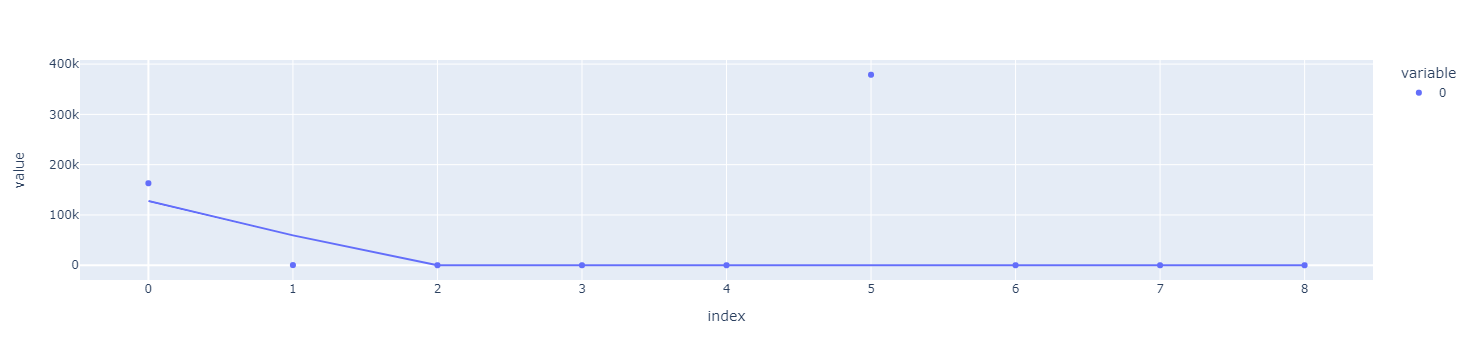

In [206]:
px.scatter(history.history["loss"],  trendline="lowess")

In [207]:
test_enc['unified_keras_api'] = model.predict([test_data[text_col], test_enc])

In [208]:
test_enc['points'] = test_y

In [209]:
stats = calc_prediction_quality(test_enc, 'unified_keras_api', target_col)
stats

MSE    4.867399
MAE    1.754912
R2     0.491964
dtype: float64

In [210]:
if 'Unified Keras API' in all_compared.index:
    all_compared = all_compared.drop(index='Unified Keras API')

In [211]:
all_compared = all_compared.append(stats.to_frame(name='Unified Keras API').transpose())
all_compared

C:\Users\hagai\AppData\Local\Temp\ipykernel_12464\976925583.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,MSE,MAE,R2
baseline_1,9.580948,2.538293,-0.000013
baseline_2,9.103050,2.471748,0.049867
baseline_3,8.521280,2.374959,0.110590
regression_by_xgb,6.266022,1.894325,0.345983
BOW,2.981564,1.360872,0.687285
NLP all features,2.818509,1.324236,0.705818
DNN_text_only_Average,3.071684,1.384459,0.679392
DNN_text_only_Concat,10.993521,2.659489,-0.147451
External_Embeddings_text_only_Concat,3.837343,1.552801,0.599477
LSTM,2.843597,1.326384,0.703199


In [212]:
# print(all_compared.to_dict())

In [213]:
data1 = {'MSE': {'baseline_1': 9.578437216323081, 'baseline_2': 9.113110977122046, 'baseline_3': 8.574999090155382, 'regression_by_xgb': 6.27931494291191, 'BOW': 2.994149954765528, 'NLP all features': 2.8755979766451403, 'DNN_text_only_Average': 3.116393438634148, 'DNN_text_only_Concat': 5.321800561734749, 'External_Embeddings_text_only_Concat': 3.8785772724660226, 'LSTM': 2.8551934527543557, 'Unified Keras API': 4.082199166205277}, 'MAE': {'baseline_1': 2.534390504344647, 'baseline_2': 2.469312967145669, 'baseline_3': 2.377418529349625, 'regression_by_xgb': 1.8935327943995333, 'BOW': 1.3680006508899043, 'NLP all features': 1.322931696614317, 'DNN_text_only_Average': 1.3965097349955147, 'DNN_text_only_Concat': 1.8298606179497503, 'External_Embeddings_text_only_Concat': 1.5576978029037616, 'LSTM': 1.3349905038676726, 'Unified Keras API': 1.5633268078939846}, 'R2': {'baseline_1': -1.7096302151742293e-10, 'baseline_2': 0.04858060110787654, 'baseline_3': 0.10476010877762865, 'regression_by_xgb': 0.344432207241015, 'BOW': 0.6880221848595143, 'NLP all features': 0.6997842223952448, 'DNN_text_only_Average': 0.6746448957397624, 'DNN_text_only_Concat': 0.44439782373105285, 'External_Embeddings_text_only_Concat': 0.5950720158692022, 'LSTM': 0.7019144784519948, 'Unified Keras API': 0.5738136530303182}}

In [214]:
final_results_table = pd.DataFrame(data=data1)

In [215]:
final_results_table["R2"] = final_results_table["R2"].round(2)

In [216]:
final_results_table

,MSE,MAE,R2
baseline_1,9.578437,2.534391,-0.00
baseline_2,9.113111,2.469313,0.05
baseline_3,8.574999,2.377419,0.10
regression_by_xgb,6.279315,1.893533,0.34
BOW,2.994150,1.368001,0.69
NLP all features,2.875598,1.322932,0.70
DNN_text_only_Average,3.116393,1.396510,0.67
DNN_text_only_Concat,5.321801,1.829861,0.44
External_Embeddings_text_only_Concat,3.878577,1.557698,0.60
LSTM,2.855193,1.334991,0.70


<div class="alert alert-block alert-warning">
<span style='background :white'> 
<span style='color:Blue'> <i>
    <b>
        ~ Done! ~
    </b>
    </i>  </span>
  </span>
    </div>

# Summary

## Results

### Results Table

In [217]:
final_results_table

,MSE,MAE,R2
baseline_1,9.578437,2.534391,-0.00
baseline_2,9.113111,2.469313,0.05
baseline_3,8.574999,2.377419,0.10
regression_by_xgb,6.279315,1.893533,0.34
BOW,2.994150,1.368001,0.69
NLP all features,2.875598,1.322932,0.70
DNN_text_only_Average,3.116393,1.396510,0.67
DNN_text_only_Concat,5.321801,1.829861,0.44
External_Embeddings_text_only_Concat,3.878577,1.557698,0.60
LSTM,2.855193,1.334991,0.70


### Results Plots

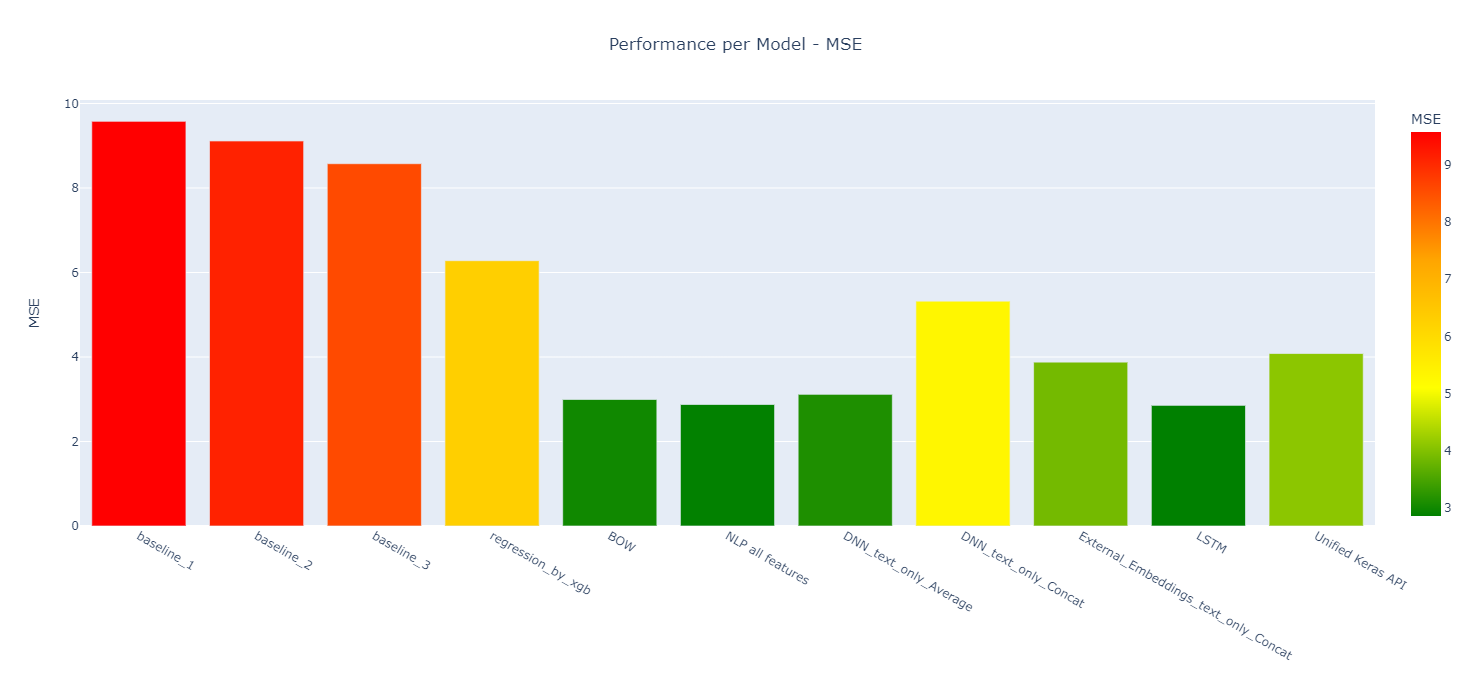

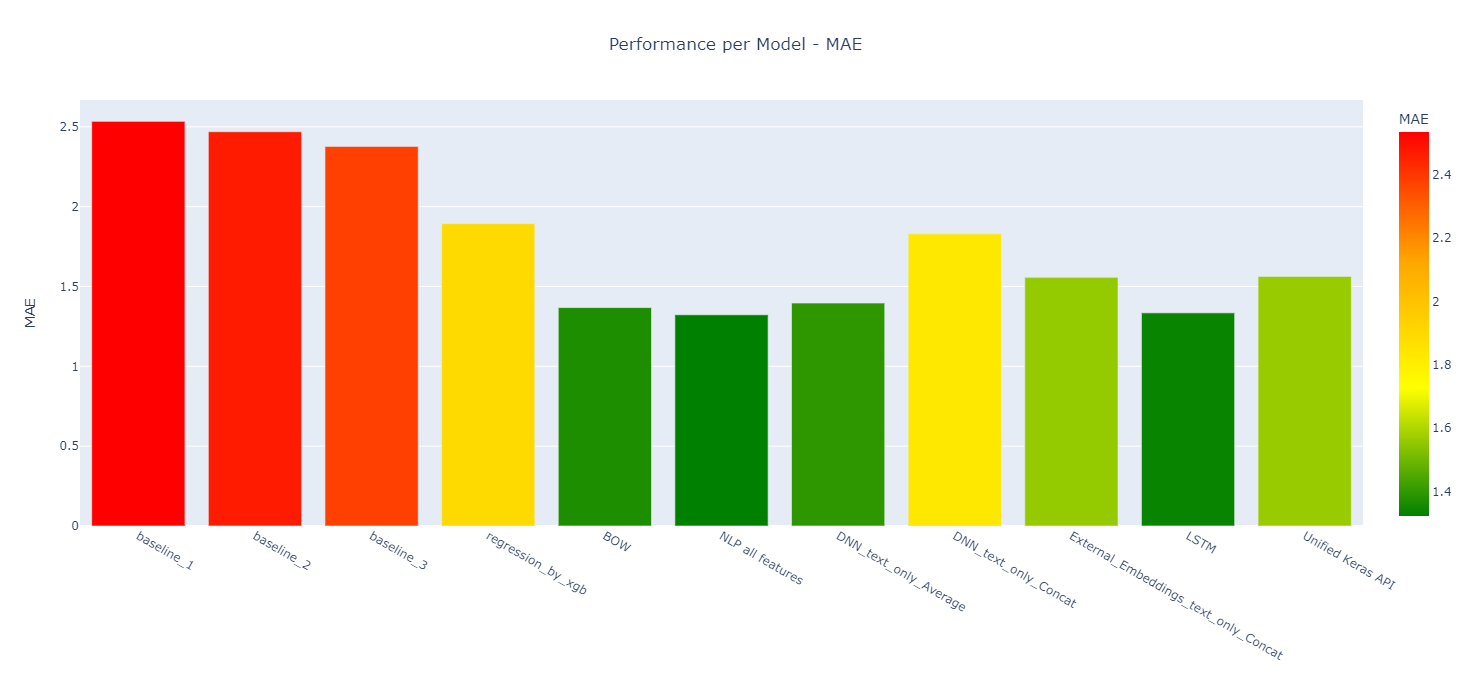

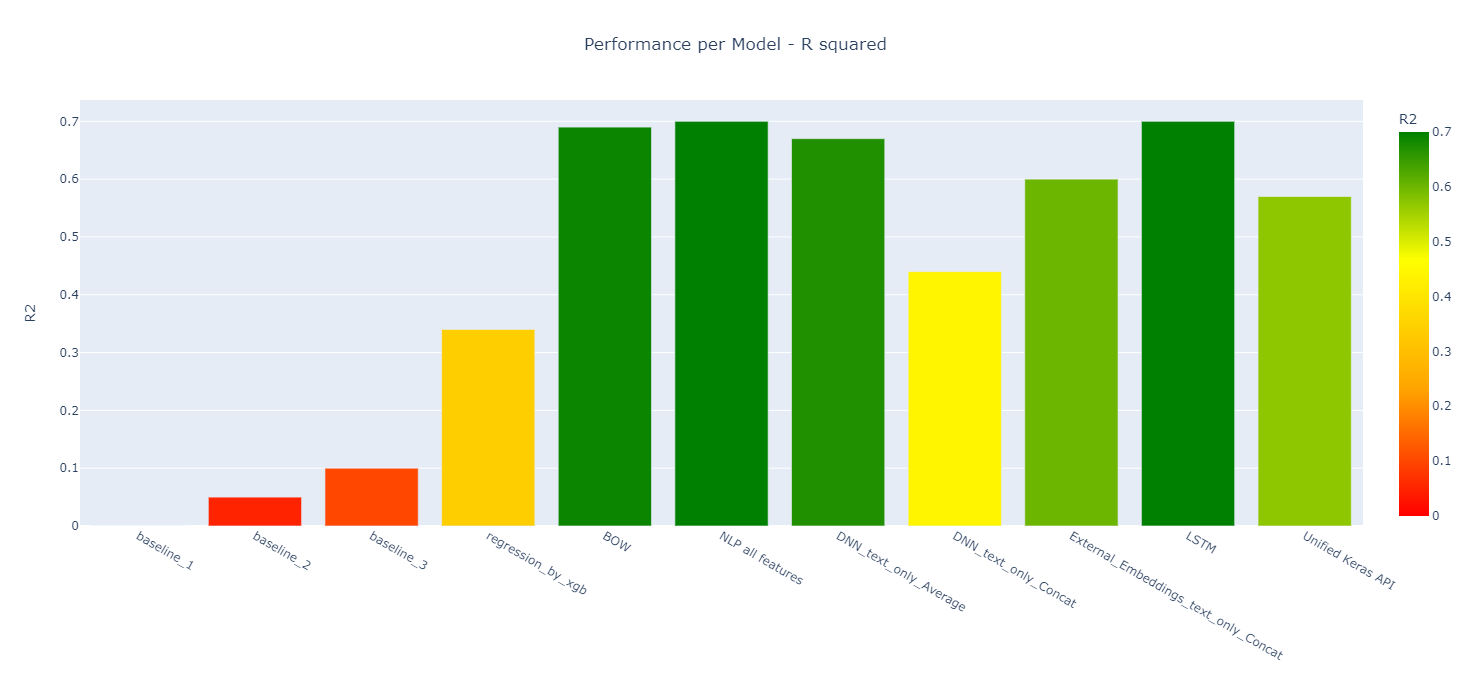

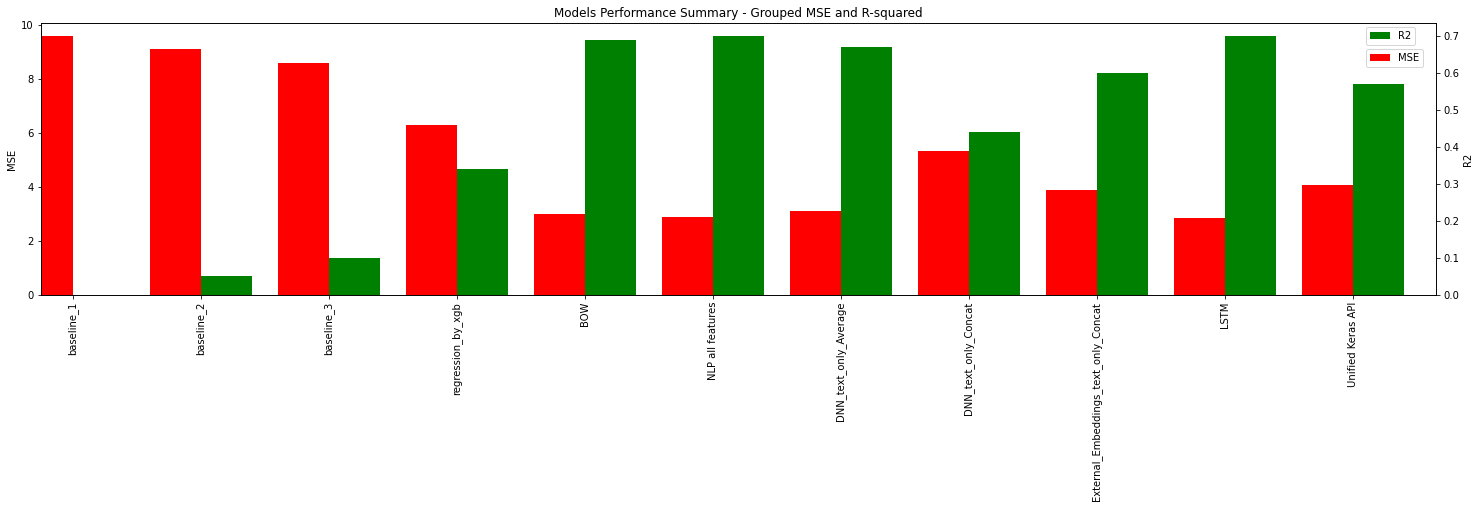

In [218]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = final_results_table.reset_index()
fig = px.bar(df, x='index', y='MSE',
              color='MSE', labels={"index":""}, title="Performance per Model - MSE",
             height=700, color_continuous_scale=["green", "yellow", "orange","red"])
fig.update_layout(title_x=0.5)
fig.show()

fig = px.bar(df, x='index', y='MAE',
              color='MAE',labels={"index":""},title="Performance per Model - MAE",
             height=700, color_continuous_scale=["green",  "yellow", "orange","red"])
fig.update_layout(title_x=0.5)
fig.show()

fig = px.bar(df, x='index', y='R2',
              color='R2',labels={"index":""},title="Performance per Model - R squared",
             height=700, color_continuous_scale=["red",  "orange","yellow", "green"])
fig.update_layout(title_x=0.5)
fig.show()


################

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,5)) # Create matplotlib figure


ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

final_results_table.MSE.plot(kind='bar', color='red', ax=ax, width=width, position=1)

final_results_table.R2.plot(kind='bar', color='green', ax=ax2, width=width, position=0)

ax.set_ylabel('MSE')
ax2.set_ylabel('R2')

ax.legend(loc=(0.95,0.84))
ax2.legend(loc=(0.95,0.92))

plt.title("Models Performance Summary - Grouped MSE and R-squared")

plt.show()

## Discussion

While high proficiency and vast experience may greatly  contribute to the choice of the most promising models, assuming the resources are available (e.g., time, computing power and budget), it is always wise to test a plethora of models, and investing in different approaches and tuning methods. This may become more true as the data grows, both in size and complexity, since different models may pick up other patterns hidden in the data, due to their inherent differences.

Here, we tried to predict the points a specific wine received, using data about the wine and its review (text) by a professional wine taster.

In this work, the best overall performance was achieved by the **“NLP all features”** and the **“LSTM”** models.

**“NLP all features”** implemented a classical Machine Learning algorithm of linear regression, while using the “ridge” regularization penalty, and utilizing a textual feature (NLP), as well as categorical and numeric features.

**“LSTM”** uses a different approach. First, like the **“BOW”** model, it only utilizes a single feature – the textual description of the wine review. While, **“BOW”** used a classical Ridge algorithm, LSTM has feedback connections which make it suffer less from the “vanishing gradients” problem, and it might be the reason it outperformed the Ridge model in this work. In addition, the LSTM approach is more affected by the more recent inputs it receives, and it is possible that the final words/sentences in the “Description” feature are the most important ones since they conclude the wine review. The **“BOW”** model’s approach weigh the words similarly if they appear in the first, or the last sentence (although in theory this changes partly when the concatenation technique is used).

Although both the **“NLP all features”** and the **“LSTM”** models achieved the same R-squared, which is supposed to say they are both able to explain about 70% of the variance of the wine review score in points (the dependent variable); it is possible to argue that perhaps **“LSTM”** explains the wine points even better. This is due to the inherent trait of the R-squared measure, which tends to increase with the number of explaining features, even if the additional features do not necessarily contribute as much to the prediction/loss. Thus, the fact that **“NLP all features”** incorporates a lot more features than **“LSTM”**, might artificially raise the R-squared value. This argument can be tested by calculating the **Adjusted** R-squared.

In any case, this performance is evidently better than any other model which was tested yet concluding whether it is “good enough” depends on the business true needs, since the performance goal was not defined a priori. 

The **“BOW”** model implemented a somewhat similar algorithm to **“NLP all features”**, but used only a single textual feature, thus using a pure classical NLP approach. If the performance difference is considered small in the stakeholders’ perspective, it is possible to consider implementing this approach instead. One would need to weigh the pros and cons which will no doubt include processing less data, can be seen as an advantage in terms of memory and computational power needs or the mere acquisition of less data, and as a con, as evidently the non-textual features do hold additional insights which help improve the model’s prediction.

The poor performance demonstrated by the **“regression_by_xgb”** and the **“DNN_text_only_Concat”** models, may suggests that the algorithm has failed to converge, or did not converge at the global minimum or even a “good” local minimum. This could happen due to different reasons such as a bug in the implementation code, a "bad" starting point or a utilization of a sub-optimal architecture (e.g., number of hidden layers, number of neurons in each layer and different activation functions).


## Conclusion

The best performance was achieved using either the **“NLP all features”** and the **“LSTM”** models.

The models **“BOW”** and **“DNN_text_only_Average”** demonstrated close performance.

The final choice depends on additional domain insights and practical aspects (e.g., data acquisition and associated spending).
